In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle
import math
import torch.nn.init as init

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchvision.transforms import Lambda
both_transform = A.Compose([A.Resize(width=256, height=256),], additional_targets={"image0": "image"},)
transform = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),ToTensorV2(),])
class GroundTruthNoisyDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.folders = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        folder_name = self.folders[idx]
        ground_truth_path = os.path.join(self.root_dir, folder_name, "gt.jpg")
        noisy_path = os.path.join(self.root_dir, folder_name, "noise.jpg")
        ground_truth = np.array(Image.open(ground_truth_path))
        noisy = np.array(Image.open(noisy_path))
        augmentations = both_transform(image=noisy, image0=ground_truth)
        noisy = augmentations["image"]
        ground_truth = augmentations["image0"]
        ground_truth = transform(image = ground_truth)["image"]
        noisy = transform(image = noisy)["image"]
        return noisy, ground_truth

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
root_tr = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Train"
root_te = "/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test"
train_dataset = GroundTruthNoisyDataset(root_tr)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = GroundTruthNoisyDataset(root_te)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [4]:
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    x, y = x.to(DEVICE), y.to(DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_out_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()

In [5]:
class ConvolutionalBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvolutionalBlock1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class CAM(nn.Module):
    def __init__(self, in_channels):
        super(CAM, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 2),
            nn.ReLU(),
            nn.Linear(2, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class PRIDNet(nn.Module):
    def __init__(self):
        super(PRIDNet, self).__init__()
        self.conv_block1 = ConvolutionalBlock1(3, 32)  # Change the input channels to 3 here
        self.cam = CAM(32)
        self.final_conv = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.cam(x)
        x = self.final_conv(x)
        return x

In [6]:
model = PRIDNet()

In [7]:
import math
import torch.nn as nn
import torch

def psnr(mse, max_pixel_val=255.0):
    return 10 * math.log10(max_pixel_val**2 / mse)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()
los = nn.MSELoss()
num_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_psnr = []
test_losses = []
test_psnr = []


for epoch in range(num_epochs):
    total_psnr_train = 0
    tot_loss_train = 0
    model.train()
    
    optimizer.zero_grad()  # Initialize gradients once at the start of each epoch

    for i, (noisy_imgs, clean_imgs) in enumerate(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        o = outputs*0.5+0.5
        c = clean_imgs*0.5+0.5
        mse = los(o*255.0,c*255.0)
        current_psnr = psnr(mse)
        total_psnr_train += current_psnr
        tot_loss_train += loss.item()  # Using loss.item() to accumulate the loss

        loss.backward()  # Calculate gradients

        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients

    avg_psnr_train = total_psnr_train / len(train_loader)
    train_losses.append(tot_loss_train / len(train_loader))
    train_psnr.append(avg_psnr_train)
    model.eval()
    total_psnr_valid = 0
    tot_loss_valid = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in valid_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            o = outputs*0.5+0.5
            c = clean_imgs*0.5+0.5
            mse = los(o*255.0,c*255.0)
            current_psnr = psnr(mse)
            total_psnr_valid += current_psnr
            tot_loss_valid += loss.item()

    avg_psnr_valid = total_psnr_valid / len(valid_loader)
    test_losses.append(tot_loss_valid / len(valid_loader))
    test_psnr.append(avg_psnr_valid)
    save_some_examples(model, valid_loader, epoch, folder="/kaggle/working/evaluation")
    print(f"Epoch [{epoch+1}/{num_epochs}], Train PSNR: {avg_psnr_train:.4f}, Valid PSNR: {avg_psnr_valid:.4f}")


Epoch [1/500], Train PSNR: 17.5703, Valid PSNR: 23.4599
Epoch [2/500], Train PSNR: 25.2382, Valid PSNR: 26.5147
Epoch [3/500], Train PSNR: 27.1015, Valid PSNR: 27.9641
Epoch [4/500], Train PSNR: 28.3022, Valid PSNR: 28.8532
Epoch [5/500], Train PSNR: 29.0923, Valid PSNR: 29.5848
Epoch [6/500], Train PSNR: 29.8801, Valid PSNR: 30.2271
Epoch [7/500], Train PSNR: 30.4122, Valid PSNR: 30.6540
Epoch [8/500], Train PSNR: 30.9933, Valid PSNR: 31.3248
Epoch [9/500], Train PSNR: 31.3249, Valid PSNR: 31.5780
Epoch [10/500], Train PSNR: 31.7080, Valid PSNR: 32.0135
Epoch [11/500], Train PSNR: 31.8984, Valid PSNR: 32.1783
Epoch [12/500], Train PSNR: 32.0109, Valid PSNR: 32.3657
Epoch [13/500], Train PSNR: 32.2362, Valid PSNR: 32.5332
Epoch [14/500], Train PSNR: 32.3707, Valid PSNR: 32.5305
Epoch [15/500], Train PSNR: 32.5352, Valid PSNR: 32.8148
Epoch [16/500], Train PSNR: 32.5852, Valid PSNR: 31.9863
Epoch [17/500], Train PSNR: 32.6594, Valid PSNR: 32.7892
Epoch [18/500], Train PSNR: 32.7280, Val

In [8]:
train_loss = []
test_loss = []
for i in train_losses:
    train_loss.append(i)
for i in test_losses:
    test_loss.append(i)

In [9]:
print("Train_loss:",train_loss[len(train_loss)-1])
print("Test_loss:",test_loss[len(test_loss)-1])

Train_loss: 0.0011543311516709447
Test_loss: 0.0011530943574722518


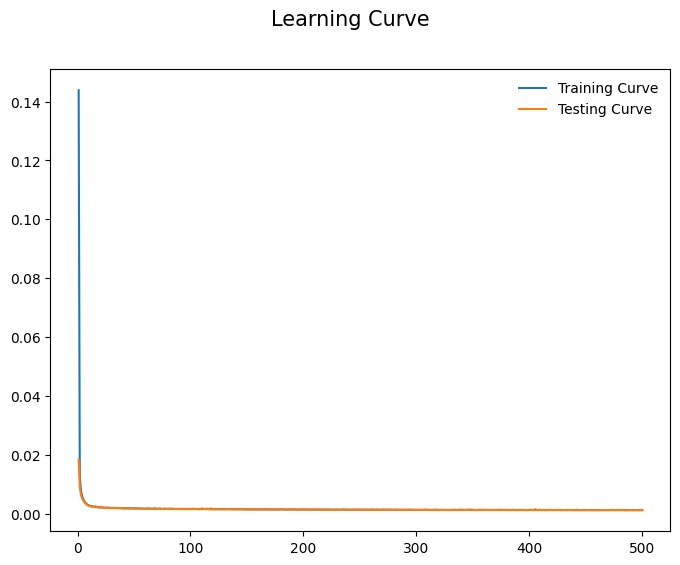

In [10]:
import matplotlib.pyplot as plt
x = [i for i in range(1,501)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("Learning Curve", fontsize = 15)
ax.plot(x, train_loss, label="Training Curve")
ax.plot(x, test_loss, label="Testing Curve")
plt.legend(loc="upper right", frameon=False)
plt.show()

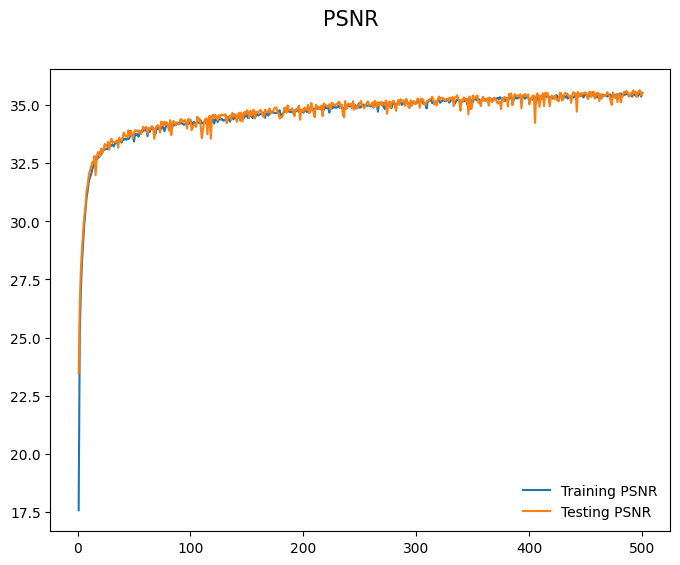

In [11]:
import matplotlib.pyplot as plt
x = [i for i in range(1,501)]
fig, ax = plt.subplots(1, figsize=(8,6))
fig.suptitle("PSNR", fontsize = 15)
ax.plot(x, train_psnr, label="Training PSNR")
ax.plot(x, test_psnr, label="Testing PSNR")
plt.legend(loc="lower right", frameon=False)
plt.show()

In [12]:
torch.save(model.state_dict(),'pridnet_cnn_256.pth')

In [13]:
from torchvision import transforms
from PIL import Image
model = PRIDNet()
model.load_state_dict(torch.load('/kaggle/working/pridnet_cnn_256.pth'))

# Create the preprocessing transformation here
transform = transforms.ToTensor()

# load your image(s)
img = Image.open('/kaggle/input/256-256-image-denoising-benchmark/Image_Denoising_Data_256/Test/pair_105_6/noise.jpg')

# Transform
input_ = transform(img)

print(input_)
input_ = input_

# unsqueeze batch dimension, in case you are dealing with a single image
input_ = input_.unsqueeze(0)

# Set model to eval
model.eval()

# Get prediction
output = model(input_)

tensor([[[0.0275, 0.0275, 0.0471,  ..., 0.0157, 0.0510, 0.0431],
         [0.0196, 0.0157, 0.0431,  ..., 0.0196, 0.0392, 0.0314],
         [0.0157, 0.0118, 0.0431,  ..., 0.0157, 0.0471, 0.0784],
         ...,
         [1.0000, 1.0000, 0.6431,  ..., 0.2627, 0.3451, 0.4549],
         [1.0000, 0.9961, 0.5843,  ..., 0.1961, 0.2353, 0.3725],
         [0.9725, 0.9686, 0.5255,  ..., 0.1725, 0.2824, 0.2902]],

        [[0.0196, 0.0118, 0.0078,  ..., 0.0627, 0.0588, 0.0314],
         [0.0196, 0.0157, 0.0196,  ..., 0.0667, 0.0471, 0.0196],
         [0.0392, 0.0353, 0.0431,  ..., 0.0627, 0.0510, 0.0588],
         ...,
         [0.9529, 0.9686, 0.6118,  ..., 0.6157, 0.6431, 0.7373],
         [0.9843, 0.9765, 0.6000,  ..., 0.5333, 0.5255, 0.6392],
         [0.9647, 0.9765, 0.5686,  ..., 0.5020, 0.5647, 0.5490]],

        [[0.0235, 0.0157, 0.0392,  ..., 0.0078, 0.0157, 0.0000],
         [0.0196, 0.0157, 0.0353,  ..., 0.0118, 0.0039, 0.0000],
         [0.0235, 0.0196, 0.0510,  ..., 0.0157, 0.0196, 0.

In [14]:
input_

tensor([[[[0.0275, 0.0275, 0.0471,  ..., 0.0157, 0.0510, 0.0431],
          [0.0196, 0.0157, 0.0431,  ..., 0.0196, 0.0392, 0.0314],
          [0.0157, 0.0118, 0.0431,  ..., 0.0157, 0.0471, 0.0784],
          ...,
          [1.0000, 1.0000, 0.6431,  ..., 0.2627, 0.3451, 0.4549],
          [1.0000, 0.9961, 0.5843,  ..., 0.1961, 0.2353, 0.3725],
          [0.9725, 0.9686, 0.5255,  ..., 0.1725, 0.2824, 0.2902]],

         [[0.0196, 0.0118, 0.0078,  ..., 0.0627, 0.0588, 0.0314],
          [0.0196, 0.0157, 0.0196,  ..., 0.0667, 0.0471, 0.0196],
          [0.0392, 0.0353, 0.0431,  ..., 0.0627, 0.0510, 0.0588],
          ...,
          [0.9529, 0.9686, 0.6118,  ..., 0.6157, 0.6431, 0.7373],
          [0.9843, 0.9765, 0.6000,  ..., 0.5333, 0.5255, 0.6392],
          [0.9647, 0.9765, 0.5686,  ..., 0.5020, 0.5647, 0.5490]],

         [[0.0235, 0.0157, 0.0392,  ..., 0.0078, 0.0157, 0.0000],
          [0.0196, 0.0157, 0.0353,  ..., 0.0118, 0.0039, 0.0000],
          [0.0235, 0.0196, 0.0510,  ..., 0

In [15]:
output

tensor([[[[-2.0910e-02,  1.7231e-02,  1.4545e-02,  ...,  5.7870e-02,
            2.9318e-02,  1.8557e-02],
          [-1.7812e-02,  4.6969e-02,  3.1535e-02,  ...,  5.9633e-02,
            4.3812e-02,  4.1961e-02],
          [ 2.9308e-02,  7.7566e-02,  5.1743e-02,  ...,  8.8942e-02,
            8.5859e-02,  7.4816e-02],
          ...,
          [ 8.2691e-01,  8.2032e-01,  6.9088e-01,  ...,  4.6341e-01,
            4.5936e-01,  4.5340e-01],
          [ 7.2283e-01,  7.7808e-01,  6.6698e-01,  ...,  3.7944e-01,
            3.2669e-01,  3.0334e-01],
          [ 4.2444e-01,  6.7864e-01,  6.8480e-01,  ...,  2.9254e-01,
            2.0515e-01,  1.8221e-01]],

         [[-3.1096e-02, -5.5527e-03,  2.0039e-03,  ...,  2.8260e-02,
            2.5630e-03, -1.8402e-02],
          [-1.9995e-02,  3.2138e-02,  1.4844e-02,  ...,  3.9772e-02,
            1.9582e-02, -6.3526e-03],
          [ 2.3427e-02,  6.4218e-02,  3.9321e-02,  ...,  6.2252e-02,
            6.2850e-02,  4.0070e-02],
          ...,
     

In [16]:
input_ = input_
output = output

In [17]:
from torchvision.utils import save_image

# Assuming 'tensor' is your tensor
img1 = input_  # Get the first image tensor
save_image(img1, 'img1.png')  # Save the tensor as an image
img2 = output
save_image(img2,'img2.png')